In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.8/258.8 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.4 MB/s eta 0:00:00


In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Question 1

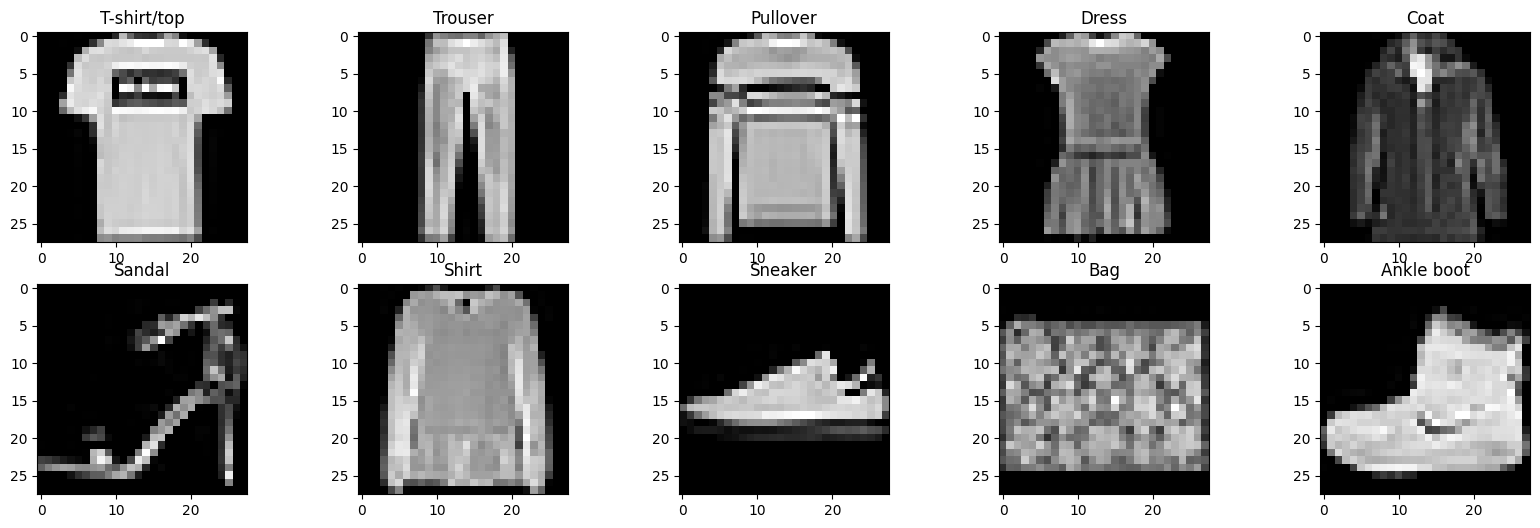

In [ ]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
import math
from keras.datasets import fashion_mnist
# from keras.utils import to_categorical

(x_train,y_train),(x_test,y_test)=fashion_mnist.load_data()
output_class=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

wandb.init(project="Pritam CS6910 - Assignment 1",name="Question 1")

img,getPlot=plt.subplots(2,5,figsize=(20,6))
getPlot=getPlot.flatten()
output_images=[]
for i in range(10):
  imgClass=np.argmax(y_train==i)
  getPlot[i].imshow(x_train[imgClass],cmap="gray")
  getPlot[i].set_title(output_class[i])
  img=wandb.Image(x_train[imgClass],caption=[output_class[i]])
  output_images.append(img)
wandb.log({"Question 1":output_images})
wandb.finish()

Question 2

In [ ]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
import math
from keras.datasets import fashion_mnist
# from keras.utils import to_categorical

(x_train,y_train),(x_test,y_test)=fashion_mnist.load_data()
validation_ratio=0.1
num_validation_samples=int(validation_ratio*x_train.shape[0])

validation_indices=np.random.choice(x_train.shape[0],num_validation_samples,replace=False)

x_val,y_val=x_train[validation_indices],y_train[validation_indices]
x_train, y_train=np.delete(x_train,validation_indices,axis=0),np.delete(y_train,validation_indices,axis=0)

In [ ]:
class Activation:
  def sigmoid(x):
    clipped_x=np.clip(x,-500,500)
    return 1/(1+np.exp(-clipped_x))

  def grad_sigmoid(x):
    clipped_x=np.clip(x,-500,500)
    s=1/(1+np.exp(-clipped_x))
    return s*(1-s)

  def tanh(x):
    return np.tanh(x)

  def grad_tanh(x):
    return 1-(np.tanh(x)**2)

  def relu(x):
    return np.maximum(x,0)

  def grad_relu(x):
    return 1*(x>0)

  def softmax(a):
    max_a=np.max(a)
    exp_a=np.exp(a-max_a)
    sum_exp=np.sum(exp_a)
    return exp_a/sum_exp
    # clipped_a=np.clip(a,-500,500)
    # return np.exp(clipped_a)/np.sum(np.exp(clipped_a),axis=0)

In [ ]:
class UpdateParameters:
  def update_parameters(W,B,eta,del_w,del_b):
    for i in range(1,len(del_w)):
      W[i]-=eta*del_w[i]
    for i in range(1,len(del_b)):
      B[i]-=eta*del_b[i]
    return W,B

  def update_parameters_mgd(W,B,del_w,del_b):
    for i in range(1,len(del_w)):
      W[i]-=del_w[i]
    for i in range(1,len(del_b)):
      B[i]-=del_b[i]
    return W,B

  def update_parameters_rms(W,B,eta,vw,vb,del_w,del_b,eps):
    for i in range(1,len(vw)):
      updated_eta=eta/(np.sqrt(np.sum(vw[i]))+eps)
      W[i]-=updated_eta*del_w[i]
    for i in range(1,len(vb)):
      updated_eta=eta/(np.sqrt(np.sum(vb[i]))+eps)
      B[i]-=updated_eta*del_b[i]
    return W,B

  def update_parameters_adam(W,B,eta,mw_hat,mb_hat,vw_hat,vb_hat,eps):
    for i in range(1,len(vw_hat)):
      updated_eta=eta/(np.sqrt(np.sum(vw_hat[i]))+eps)
      W[i]-=updated_eta*mw_hat[i]
    for i in range(1,len(vb_hat)):
      updated_eta=eta/(np.sqrt(np.sum(vb_hat[i]))+eps)
      B[i]-=updated_eta*mb_hat[i]
    return W,B

  def update_parameters_nadam(W,B,eta,mw_hat,mb_hat,vw_hat,vb_hat,beta1,beta2,del_w,del_b,eps):
    for i in range(1,len(vw_hat)):
      W[i]-=(eta/(np.sqrt(vw_hat[i])+eps))*((beta1*mw_hat[i])+(((1-beta1)*del_w[i])/(1-beta1**(i+1))))
    for i in range(1,len(vb_hat)):
      B[i]-=(eta/(np.sqrt(vb_hat[i])+eps))*((beta1*mb_hat[i])+(((1-beta1)*del_b[i])/(1-beta1**(i+1))))
    return W,B

  def normalizeParameters(W,B):
    for i in range(1,len(W)):
      W[i]=W[i]/np.linalg.norm(W[i])
    for i in range(1,len(B)):
      B[i]=B[i]/np.linalg.norm(B[i])
    return W,B


In [ ]:
class ParamaterInitialization:
  def initializeW(initialization,num_of_layers,neurons_in_hl,x_train_shape,y_train_shape):
    w=dict()
    if(initialization=="random"):
      w[1]=np.random.randn(neurons_in_hl,x_train_shape).astype(np.float128)
      for i in range(2,num_of_layers-1):
        w[i]=np.random.randn(neurons_in_hl,neurons_in_hl).astype(np.float128)
      w[num_of_layers-1]=np.random.randn(y_train_shape,neurons_in_hl).astype(np.float128)

    else:
      w[1]=(np.random.randn(neurons_in_hl,x_train_shape)/np.sqrt(x_train_shape)).astype(np.float128)
      for i in range(2,num_of_layers-1):
        w[i]=(np.random.randn(neurons_in_hl, neurons_in_hl)/np.sqrt(neurons_in_hl)).astype(np.float128)
      w[num_of_layers-1]=(np.random.randn(y_train_shape,neurons_in_hl)/np.sqrt(neurons_in_hl)).astype(np.float128)

    return w

  def initializeB(initialization,num_of_layers,neurons_in_hl,x_train_shape,y_train_shape):
    b=dict()
    if(initialization=="random"):
      for i in range(1,num_of_layers-1):
        b[i]=np.random.randn(neurons_in_hl).astype(np.float128)
      b[num_of_layers-1]=np.random.randn(y_train_shape).astype(np.float128)

    else:
      for i in range(1,num_of_layers-1):
        b[i]=(np.random.randn(neurons_in_hl)/np.sqrt(neurons_in_hl)).astype(np.float128)
      b[num_of_layers-1]=(np.random.randn(y_train_shape)/np.sqrt(neurons_in_hl)).astype(np.float128)

    return b

In [ ]:
class FeedForwardNeuralNetwork:

  epochs=0
  hls=0
  neurons_in_hl=0
  eta=0.0
  activation=0
  num_of_layers=0
  x_train=np.zeros(784)
  y_train=np.zeros(10)
  W=dict()
  B=dict()

  def __init__ (self,x_train1,y_train1,x_val1,y_val1,hls,neurons_in_hl,activation,initialization,epochs,eta):
    self.epochs=epochs
    self.hls=hls
    self.neurons_in_hl=neurons_in_hl
    self.eta=eta
    self.activation=activation
    self.num_of_layers=hls+2
    self.initialization=initialization

    self.x_train=self.input_flattening(x_train1)
    self.y_train=self.one_hot_encoding(y_train1)

    self.x_val=self.input_flattening(x_val1)
    self.y_val=self.one_hot_encoding(y_val1)

    self.W=ParamaterInitialization.initializeW(self.initialization,self.num_of_layers,self.neurons_in_hl,self.x_train.shape[1],self.y_train.shape[1])
    self.B=ParamaterInitialization.initializeB(self.initialization,self.num_of_layers,self.neurons_in_hl,self.x_train.shape[1],self.y_train.shape[1])


  def one_hot_encoding(self,y):
    temp=list()
    for i in range(y.shape[0]):
      vector=np.zeros(10)
      vector[y[i]]=1
      temp.append(vector)
    return np.array(temp)

  def input_flattening(self,x):
    return x.reshape(x.shape[0],-1)/255.0

  def incerement_grad(self,a,x):
    for i in range(1,len(a)):
      a[i]+=x[i]
    return a

  def initGrads(self):
    del_w=dict()
    del_w[1]=np.zeros((self.neurons_in_hl,self.x_train.shape[1]), dtype=np.float128)
    for i in range(2,self.num_of_layers-1):
      del_w[i]=np.zeros((self.neurons_in_hl,self.neurons_in_hl), dtype=np.float128)
    del_w[self.num_of_layers-1]=np.zeros((self.y_train.shape[1],self.neurons_in_hl), dtype=np.float128)

    del_b=dict()
    for i in range(1,self.num_of_layers-1):
      del_b[i]=np.zeros(self.neurons_in_hl, dtype=np.float128)
    del_b[self.num_of_layers-1]=np.zeros(self.y_train.shape[1], dtype=np.float128)

    return del_w,del_b


  def forward_propagation(self,w,b,x):
    h=dict()
    a=dict()

    h[0]=x

    for k in range(1,self.num_of_layers-1):
      a[k]=b[k]+np.dot(w[k],h[k-1])
      if(self.activation=="sigmoid"):
        h[k]=Activation.sigmoid(a[k])
      elif(self.activation=="tanh"):
        h[k]=Activation.tanh(a[k])
      else:
        h[k]=Activation.relu(a[k])

    a[self.num_of_layers-1]=b[self.num_of_layers-1]+np.dot(w[self.num_of_layers-1],h[self.num_of_layers-2])
    y_cap=Activation.softmax(a[self.hls+1])

    return a,h,y_cap

  def backward_propagation(self,h,a,y,y_cap):
    del_a=dict()
    del_w=dict()
    del_b=dict()
    del_h=dict()

    del_a[self.num_of_layers-1]=-(y-y_cap)
    for k in range(self.num_of_layers-1,0,-1):
      del_w[k]=np.outer(del_a[k],h[k-1])
      del_b[k]=del_a[k]
      del_h[k-1]=np.dot(self.W[k].T,del_a[k])
      if k>1:
        if(self.activation=="sigmoid"):
          del_a[k-1]=np.multiply(del_h[k-1],Activation.grad_sigmoid(a[k-1]))
        elif(self.activation=="tanh"):
          del_a[k-1]=np.multiply(del_h[k-1],Activation.grad_tanh(a[k-1]))
        else:
          del_a[k-1]=np.multiply(del_h[k-1],Activation.grad_relu(a[k-1]))

    return (del_w,del_b)

  def gradient_descent(self):
    for iter in range(self.epochs):
      del_w,del_b=self.initGrads()
      for x,y in zip(self.x_train,self.y_train):
        A,H,y_cap=self.forward_propagation(self.W,self.B,x)
        ret=self.backward_propagation(H,A,y,y_cap)
        del_w=self.incerement_grad(del_w,ret[0])
        del_b=self.incerement_grad(del_b,ret[1])
      self.W,self.B=UpdateParameters.update_parameters(self.W,self.B,self.eta,del_w,del_b)
    return self.W,self.B

  def stochastic_gradient_descent(self,batch_size):
    trainLossPerEpoch=list()
    trainAccuracyPerEpoch=list()
    valLossPerEpoch=list()
    valAccuracyPerEpoch=list()

    for iter in range(self.epochs):
      predictions=list()
      del_w,del_b=self.initGrads()
      num_of_points_seen=0
      for x,y in zip(self.x_train,self.y_train):
        A,H,y_cap=self.forward_propagation(self.W,self.B,x)
        predictions.append(y_cap)
        ret=self.backward_propagation(H,A,y,y_cap)
        del_w=self.incerement_grad(del_w,ret[0])
        del_b=self.incerement_grad(del_b,ret[1])
        num_of_points_seen+=1

        if(num_of_points_seen%batch_size==0):
          self.W,self.B=UpdateParameters.update_parameters(self.W,self.B,self.eta,del_w,del_b)
          del_w,del_b=self.initGrads()

      trainLossPerEpoch.append(Loss.trainCrossEntropyLoss(self.y_train,np.array(predictions))/x_train.shape[0])
      trainAccuracyPerEpoch.append(Accuracy.trainAccuracy(self.y_train,np.array(predictions)))
      valLossPerEpoch.append(Loss.valCrossEntropyLoss(self,self.W,self.B,self.x_val,self.y_val)/x_val.shape[0])
      valAccuracyPerEpoch.append(Accuracy.valAccuracy(self,self.W,self.B,self.x_val,self.y_val))
      if(math.isnan(trainLossPerEpoch[-1])):
        trainLossPerEpoch[-1]=0
      if(math.isnan(valLossPerEpoch[-1])):
        valLossPerEpoch[-1]=0
      print("********************************")
      print("Epoch Number = {}".format(iter))
      print("Training Accuracy = {}".format(trainAccuracyPerEpoch[-1]))
      print("Validation Accuracy = {}".format(valAccuracyPerEpoch[-1]))
      wandb.log({"training accuracy":trainAccuracyPerEpoch[-1],"validation accuracy":valAccuracyPerEpoch[-1],"training loss":trainLossPerEpoch[-1],"validation loss":valLossPerEpoch[-1],"Epoch":iter})
      self.W,self.B=UpdateParameters.normalizeParameters(self.W,self.B)

    return trainLossPerEpoch,trainAccuracyPerEpoch,valLossPerEpoch,valAccuracyPerEpoch

  def momentum_gradient_descent(self,beta,batch_size):
    trainLossPerEpoch=list()
    trainAccuracyPerEpoch=list()
    valLossPerEpoch=list()
    valAccuracyPerEpoch=list()

    prev_uw,prev_ub=self.initGrads()
    for iter in range(self.epochs):
      predictions=list()
      del_w,del_b=self.initGrads()
      num_of_points_seen=0
      for x,y in zip(self.x_train,self.y_train):
        A,H,y_cap=self.forward_propagation(self.W,self.B,x)
        predictions.append(y_cap)
        ret=self.backward_propagation(H,A,y,y_cap)
        del_w=self.incerement_grad(del_w,ret[0])
        del_b=self.incerement_grad(del_b,ret[1])
        num_of_points_seen+=1

        if(num_of_points_seen%batch_size==0):
          uw,ub=dict(),dict()
          for i in range(1,len(del_w)):
            uw[i]=beta*prev_uw[i]+self.eta*del_w[i]
            ub[i]=beta*prev_ub[i]+self.eta*del_b[i]

          self.W,self.B=UpdateParameters.update_parameters_mgd(self.W,self.B,uw,ub)
          prev_uw=uw
          prev_ub=ub
          del_w,del_b=self.initGrads()

      trainLossPerEpoch.append(Loss.trainCrossEntropyLoss(self.y_train,np.array(predictions))/x_train.shape[0])
      trainAccuracyPerEpoch.append(Accuracy.trainAccuracy(self.y_train,np.array(predictions)))
      valLossPerEpoch.append(Loss.valCrossEntropyLoss(self,self.W,self.B,self.x_val,self.y_val)/x_val.shape[0])
      valAccuracyPerEpoch.append(Accuracy.valAccuracy(self,self.W,self.B,self.x_val,self.y_val))
      if(math.isnan(trainLossPerEpoch[-1])):
        trainLossPerEpoch[-1]=0
      if(math.isnan(valLossPerEpoch[-1])):
        valLossPerEpoch[-1]=0
      print("********************************")
      print("Epoch Number = {}".format(iter))
      print("Training Accuracy = {}".format(trainAccuracyPerEpoch[-1]))
      print("Validation Accuracy = {}".format(valAccuracyPerEpoch[-1]))
      wandb.log({"training accuracy":trainAccuracyPerEpoch[-1],"validation accuracy":valAccuracyPerEpoch[-1],"training loss":trainLossPerEpoch[-1],"validation loss":valLossPerEpoch[-1],"Epoch":iter})
      self.W,self.B=UpdateParameters.normalizeParameters(self.W,self.B)

    return trainLossPerEpoch,trainAccuracyPerEpoch,valLossPerEpoch,valAccuracyPerEpoch

  def nestrov_gradient_descent(self,beta,batch_size):
    trainLossPerEpoch=list()
    trainAccuracyPerEpoch=list()
    valLossPerEpoch=list()
    valAccuracyPerEpoch=list()

    prev_uw,prev_ub=self.initGrads()

    for iter in range(self.epochs):
      predictions=list()
      del_w,del_b=self.initGrads()
      uw,ub=dict(),dict()
      for i in range(1,len(del_w)):
        uw[i]=beta*prev_uw[i]
        ub[i]=beta*prev_ub[i]

      w,b=UpdateParameters.update_parameters_mgd(self.W,self.B,uw,ub)
      num_of_points_seen=0

      for x,y in zip(self.x_train,self.y_train):
        A,H,y_cap=self.forward_propagation(w,b,x)
        predictions.append(y_cap)
        ret=self.backward_propagation(H,A,y,y_cap)
        del_w=self.incerement_grad(del_w,ret[0])
        del_b=self.incerement_grad(del_b,ret[1])
        num_of_points_seen+=1

        if(num_of_points_seen%batch_size==0):
          for i in range(1,len(del_w)):
            uw[i]=beta*prev_uw[i]+self.eta*del_w[i]
            ub[i]=beta*prev_ub[i]+self.eta*del_b[i]

          self.W,self.B=UpdateParameters.update_parameters_mgd(self.W,self.B,uw,ub)
          prev_uw=uw
          prev_ub=ub
          del_w,del_b=self.initGrads()

      trainLossPerEpoch.append(Loss.trainCrossEntropyLoss(self.y_train,np.array(predictions))/x_train.shape[0])
      trainAccuracyPerEpoch.append(Accuracy.trainAccuracy(self.y_train,np.array(predictions)))
      valLossPerEpoch.append(Loss.valCrossEntropyLoss(self,self.W,self.B,self.x_val,self.y_val)/x_val.shape[0])
      valAccuracyPerEpoch.append(Accuracy.valAccuracy(self,self.W,self.B,self.x_val,self.y_val))
      if(math.isnan(trainLossPerEpoch[-1])):
        trainLossPerEpoch[-1]=0
      if(math.isnan(valLossPerEpoch[-1])):
        valLossPerEpoch[-1]=0
      print("********************************")
      print("Epoch Number = {}".format(iter))
      print("Training Accuracy = {}".format(trainAccuracyPerEpoch[-1]))
      print("Validation Accuracy = {}".format(valAccuracyPerEpoch[-1]))
      wandb.log({"training accuracy":trainAccuracyPerEpoch[-1],"validation accuracy":valAccuracyPerEpoch[-1],"training loss":trainLossPerEpoch[-1],"validation loss":valLossPerEpoch[-1],"Epoch":iter})
      self.W,self.B=UpdateParameters.normalizeParameters(self.W,self.B)

    return trainLossPerEpoch,trainAccuracyPerEpoch,valLossPerEpoch,valAccuracyPerEpoch


  def rmsprop(self,beta,eps,batch_size):
    trainLossPerEpoch=list()
    trainAccuracyPerEpoch=list()
    valLossPerEpoch=list()
    valAccuracyPerEpoch=list()

    vw,vb=self.initGrads()

    for iter in range(self.epochs):
      predictions=list()
      del_w,del_b=self.initGrads()
      num_of_points_seen=0
      for x,y in zip(self.x_train,self.y_train):
        A,H,y_cap=self.forward_propagation(self.W,self.B,x)
        predictions.append(y_cap)
        ret=self.backward_propagation(H,A,y,y_cap)
        del_w=self.incerement_grad(del_w,ret[0])
        del_b=self.incerement_grad(del_b,ret[1])
        num_of_points_seen+=1

        if(num_of_points_seen%batch_size==0):
          for i in range(1,len(del_w)):
            vw[i]=(beta*vw[i])+((1-beta)*(del_w[i]**2))
            vb[i]=(beta*vb[i])+((1-beta)*(del_b[i]**2))

          self.W,self.B=UpdateParameters.update_parameters_rms(self.W,self.B,self.eta,vw,vb,del_w,del_b,eps)
          del_w,del_b=self.initGrads()

      trainLossPerEpoch.append(Loss.trainCrossEntropyLoss(self.y_train,np.array(predictions))/x_train.shape[0])
      trainAccuracyPerEpoch.append(Accuracy.trainAccuracy(self.y_train,np.array(predictions)))
      valLossPerEpoch.append(Loss.valCrossEntropyLoss(self,self.W,self.B,self.x_val,self.y_val)/x_val.shape[0])
      valAccuracyPerEpoch.append(Accuracy.valAccuracy(self,self.W,self.B,self.x_val,self.y_val))
      if(math.isnan(trainLossPerEpoch[-1])):
        trainLossPerEpoch[-1]=0
      if(math.isnan(valLossPerEpoch[-1])):
        valLossPerEpoch[-1]=0
      print("********************************")
      print("Epoch Number = {}".format(iter))
      print("Training Accuracy = {}".format(trainAccuracyPerEpoch[-1]))
      print("Validation Accuracy = {}".format(valAccuracyPerEpoch[-1]))
      wandb.log({"training accuracy":trainAccuracyPerEpoch[-1],"validation accuracy":valAccuracyPerEpoch[-1],"training loss":trainLossPerEpoch[-1],"validation loss":valLossPerEpoch[-1],"Epoch":iter})
      self.W,self.B=UpdateParameters.normalizeParameters(self.W,self.B)

    return trainLossPerEpoch,trainAccuracyPerEpoch,valLossPerEpoch,valAccuracyPerEpoch


  def adam(self,beta1,beta2,eps,batch_size):
    trainLossPerEpoch=list()
    trainAccuracyPerEpoch=list()
    valLossPerEpoch=list()
    valAccuracyPerEpoch=list()

    vw,vb=self.initGrads()
    mw,mb=self.initGrads()
    mw_hat,mb_hat=self.initGrads()
    vw_hat,vb_hat=self.initGrads()

    for iter in range(self.epochs):
      predictions=list()
      del_w,del_b=self.initGrads()
      num_of_points_seen=0
      for x,y in zip(self.x_train,self.y_train):
        A,H,y_cap=self.forward_propagation(self.W,self.B,x)
        predictions.append(y_cap)
        ret=self.backward_propagation(H,A,y,y_cap)
        del_w=self.incerement_grad(del_w,ret[0])
        del_b=self.incerement_grad(del_b,ret[1])
        num_of_points_seen+=1

        if(num_of_points_seen%batch_size==0):
          for i in range(1,len(del_w)):
            mw[i]=(beta1*mw[i])+((1-beta1)*del_w[i])
            mb[i]=(beta1*mb[i])+((1-beta1)*del_b[i])
            vw[i]=(beta2*vw[i])+((1-beta2)*(del_w[i]**2))
            vb[i]=(beta2*vb[i])+((1-beta2)*(del_b[i]**2))

          for i in range(1,len(del_w)):
            mw_hat[i]=mw[i]/(1-np.power(beta1,i+1))
            mb_hat[i]=mb[i]/(1-np.power(beta1,i+1))
            vw_hat[i]=vw[i]/(1-np.power(beta2,i+1))
            vb_hat[i]=vb[i]/(1-np.power(beta2,i+1))

          del_w,del_b=self.initGrads()
          self.W,self.B=UpdateParameters.update_parameters_adam(self.W,self.B,self.eta,mw_hat,mb_hat,vw_hat,vb_hat,eps)

      trainLossPerEpoch.append(Loss.trainCrossEntropyLoss(self.y_train,np.array(predictions))/x_train.shape[0])
      trainAccuracyPerEpoch.append(Accuracy.trainAccuracy(self.y_train,np.array(predictions)))
      valLossPerEpoch.append(Loss.valCrossEntropyLoss(self,self.W,self.B,self.x_val,self.y_val)/x_val.shape[0])
      valAccuracyPerEpoch.append(Accuracy.valAccuracy(self,self.W,self.B,self.x_val,self.y_val))
      if(math.isnan(trainLossPerEpoch[-1])):
        trainLossPerEpoch[-1]=0
      if(math.isnan(valLossPerEpoch[-1])):
        valLossPerEpoch[-1]=0
      print("********************************")
      print("Epoch Number = {}".format(iter))
      print("Training Accuracy = {}".format(trainAccuracyPerEpoch[-1]))
      print("Validation Accuracy = {}".format(valAccuracyPerEpoch[-1]))
      wandb.log({"training accuracy":trainAccuracyPerEpoch[-1],"validation accuracy":valAccuracyPerEpoch[-1],"training loss":trainLossPerEpoch[-1],"validation loss":valLossPerEpoch[-1],"Epoch":iter})
      self.W,self.B=UpdateParameters.normalizeParameters(self.W,self.B)

    return trainLossPerEpoch,trainAccuracyPerEpoch,valLossPerEpoch,valAccuracyPerEpoch


  def nadam(self,beta1,beta2,eps,batch_size):
    trainLossPerEpoch=list()
    trainAccuracyPerEpoch=list()
    valLossPerEpoch=list()
    valAccuracyPerEpoch=list()

    vw,vb=self.initGrads()
    mw,mb=self.initGrads()
    mw_hat,mb_hat=self.initGrads()
    vw_hat,vb_hat=self.initGrads()

    for iter in range(self.epochs):
      predictions=list()
      del_w,del_b=self.initGrads()
      num_of_points_seen=0
      for x,y in zip(self.x_train,self.y_train):
        A,H,y_cap=self.forward_propagation(self.W,self.B,x)
        predictions.append(y_cap)
        ret=self.backward_propagation(H,A,y,y_cap)
        del_w=self.incerement_grad(del_w,ret[0])
        del_b=self.incerement_grad(del_b,ret[1])
        num_of_points_seen+=1

        if(num_of_points_seen%batch_size==0):
          for i in range(1,len(del_w)):
            mw[i]=(beta1*mw[i])+((1-beta1)*del_w[i])
            mb[i]=(beta1*mb[i])+((1-beta1)*del_b[i])
            vw[i]=(beta2*vw[i])+((1-beta2)*(del_w[i]**2))
            vb[i]=(beta2*vb[i])+((1-beta2)*(del_b[i]**2))

          for i in range(1,len(del_w)):
            mw_hat[i]=mw[i]/(1-np.power(beta1,i+1))
            mb_hat[i]=mb[i]/(1-np.power(beta1,i+1))
            vw_hat[i]=vw[i]/(1-np.power(beta2,i+1))
            vb_hat[i]=vb[i]/(1-np.power(beta2,i+1))

          self.W,self.B=UpdateParameters.update_parameters_nadam(self.W,self.B,self.eta,mw_hat,mb_hat,vw_hat,vb_hat,beta1,beta2,del_w,del_b,eps)
          del_w,del_b=self.initGrads()

      trainLossPerEpoch.append(Loss.trainCrossEntropyLoss(self.y_train,np.array(predictions))/x_train.shape[0])
      trainAccuracyPerEpoch.append(Accuracy.trainAccuracy(self.y_train,np.array(predictions)))
      valLossPerEpoch.append(Loss.valCrossEntropyLoss(self,self.W,self.B,self.x_val,self.y_val)/x_val.shape[0])
      valAccuracyPerEpoch.append(Accuracy.valAccuracy(self,self.W,self.B,self.x_val,self.y_val))
      if(math.isnan(trainLossPerEpoch[-1])):
        trainLossPerEpoch[-1]=0
      if(math.isnan(valLossPerEpoch[-1])):
        valLossPerEpoch[-1]=0
      print("********************************")
      print("Epoch Number = {}".format(iter))
      print("Training Accuracy = {}".format(trainAccuracyPerEpoch[-1]))
      print("Validation Accuracy = {}".format(valAccuracyPerEpoch[-1]))
      wandb.log({"training accuracy":trainAccuracyPerEpoch[-1],"validation accuracy":valAccuracyPerEpoch[-1],"training loss":trainLossPerEpoch[-1],"validation loss":valLossPerEpoch[-1],"Epoch":iter})
      self.W,self.B=UpdateParameters.normalizeParameters(self.W,self.B)

    return trainLossPerEpoch,trainAccuracyPerEpoch,valLossPerEpoch,valAccuracyPerEpoch


  def modelFitting(self,beta,beta1,beta2,eps,optimizer,batch_size,loss):
    run_name="lr_{}_op_{}_bs_{}_loss_{}_wInit_{}_hls_{}_nhls_{}_ac_{}".format(self.eta,optimizer,batch_size,loss,self.initialization,self.hls,self.neurons_in_hl, self.activation)
    print("run name = {}".format(run_name))
    wandb.run.name=run_name
    trainLossPerEpoch=list()
    trainAccuracyPerEpoch=list()
    valLossPerEpoch=list()
    valAccuracyPerEpoch=list()

    if(optimizer=="sgd"):
      trainLossPerEpoch,trainAccuracyPerEpoch,valLossPerEpoch,valAccuracyPerEpoch=self.stochastic_gradient_descent(batch_size)
    elif(optimizer=="momentum"):
      trainLossPerEpoch,trainAccuracyPerEpoch,valLossPerEpoch,valAccuracyPerEpoch=self.momentum_gradient_descent(beta,batch_size)
    elif(optimizer=="nestrov"):
      trainLossPerEpoch,trainAccuracyPerEpoch,valLossPerEpoch,valAccuracyPerEpoch=self.nestrov_gradient_descent(beta,batch_size)
    elif(optimizer=="rmsprop"):
      trainLossPerEpoch,trainAccuracyPerEpoch,valLossPerEpoch,valAccuracyPerEpoch=self.rmsprop(beta,eps,batch_size)
    elif(optimizer=="adam"):
      trainLossPerEpoch,trainAccuracyPerEpoch,valLossPerEpoch,valAccuracyPerEpoch=self.adam(beta1,beta2,eps,batch_size)
    elif(optimizer=="nadam"):
      trainLossPerEpoch,trainAccuracyPerEpoch,valLossPerEpoch,valAccuracyPerEpoch=self.nadam(beta1,beta2,eps,batch_size)


    plt.plot(trainLossPerEpoch,label='Train Loss')
    plt.plot(valLossPerEpoch,label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('cost')
    plt.legend()
    plt.show()
    plt.plot(trainAccuracyPerEpoch,label='Train Accuracy')
    plt.plot(valAccuracyPerEpoch,label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()


In [ ]:
class Accuracy:
  def trainAccuracy(y,y_pred):
    accuracy=0
    for i in range(y.shape[0]):
      if(np.argmax(y[i])==np.argmax(y_pred[i])):
        accuracy+=1

    return accuracy/y.shape[0]

  def valAccuracy(Model,w,b,x,y):
    accuracy=0
    for i in range(x.shape[0]):
      a,h,y_pred=Model.forward_propagation(w,b,x[i])
      if(np.argmax(y[i])==np.argmax(y_pred)):
        accuracy+=1

    return accuracy/x.shape[0]


In [ ]:
class Loss:
  def trainCrossEntropyLoss(y,yPred):
    return -np.sum(y*np.log(yPred+1e-9))

  def valCrossEntropyLoss(Model,w,b,x,y):
    yPred1=list()
    for i in range(x.shape[0]):
      a,h,y_pred=Model.forward_propagation(w,b,x[i])
      yPred1.append(y_pred)
    yPred=np.array(yPred1)
    return -np.sum(y*np.log(yPred+1e-9))


Create sweep with ID: tzsl545u
Sweep URL: https://wandb.ai/cs23m051/Pritam%20CS6910%20-%20Assignment%201/sweeps/tzsl545u


wandb: Agent Starting Run: 7swj2dp8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta: 0.999
wandb: 	epochs: 5
wandb: 	initialization: xavier
wandb: 	learning_rate: 0.01
wandb: 	loss: cross_entropy
wandb: 	num_neurons_in_hidden_layers: 32
wandb: 	number_of_hidden_layers: 5
wandb: 	optimizer: nestrov
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


run name = lr_0.01_op_nestrov_bs_64_loss_cross_entropy_wInit_xavier_hls_5_nhls_32_ac_relu
********************************
Epoch Number = 0
Training Accuracy = 0.10416666666666667
Validation Accuracy = 0.103
********************************
Epoch Number = 1
Training Accuracy = 0.09966666666666667
Validation Accuracy = 0.103
********************************
Epoch Number = 2
Training Accuracy = 0.0994074074074074
Validation Accuracy = 0.103
********************************
Epoch Number = 3
Training Accuracy = 0.09966666666666667
Validation Accuracy = 0.103
********************************
Epoch Number = 4
Training Accuracy = 0.09966666666666667
Validation Accuracy = 0.103


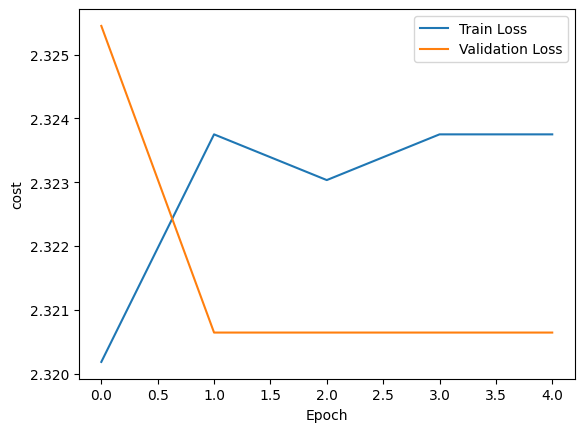

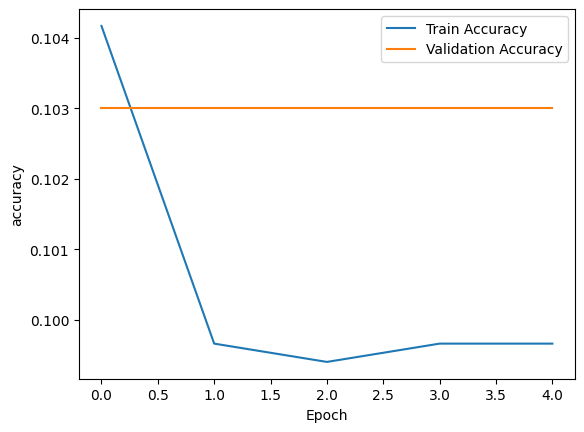

Epoch,▁▃▅▆█
training accuracy,█▁▁▁▁
training loss,▁█▇██
validation accuracy,▁▁▁▁▁
validation loss,█▁▁▁▁
Epoch,4
training accuracy,0.09967
training loss,2.32375
validation accuracy,0.103
validation loss,2.32064


wandb: Agent Starting Run: poyyvncm with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	epochs: 10
wandb: 	initialization: random
wandb: 	learning_rate: 0.1
wandb: 	loss: cross_entropy
wandb: 	num_neurons_in_hidden_layers: 64
wandb: 	number_of_hidden_layers: 4
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


run name = lr_0.1_op_adam_bs_64_loss_cross_entropy_wInit_random_hls_4_nhls_64_ac_relu
********************************
Epoch Number = 0
Training Accuracy = 0.5070740740740741
Validation Accuracy = 0.5986666666666667
********************************
Epoch Number = 1
Training Accuracy = 0.09985185185185186
Validation Accuracy = 0.09283333333333334
********************************
Epoch Number = 2
Training Accuracy = 0.1002962962962963
Validation Accuracy = 0.09283333333333334
********************************
Epoch Number = 3
Training Accuracy = 0.10037037037037037
Validation Accuracy = 0.09283333333333334
********************************
Epoch Number = 5
Training Accuracy = 0.09898148148148148
Validation Accuracy = 0.09283333333333334
********************************
Epoch Number = 6
Training Accuracy = 0.09614814814814815
Validation Accuracy = 0.101
********************************
Epoch Number = 7
Training Accuracy = 0.09638888888888889
Validation Accuracy = 0.101
*********************

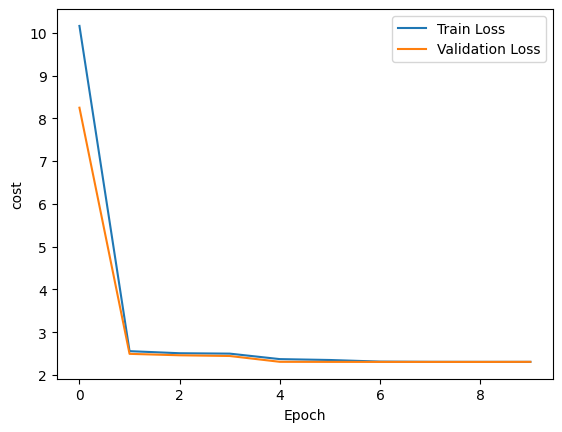

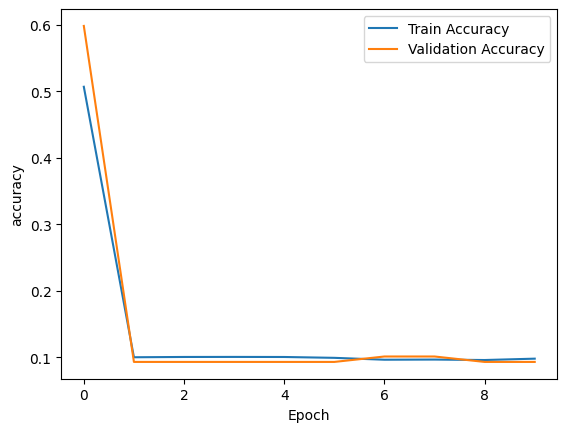

Epoch,▁▂▃▃▄▅▆▆▇█
training accuracy,█▁▁▁▁▁▁▁▁▁
training loss,█▁▁▁▁▁▁▁▁▁
validation accuracy,█▁▁▁▁▁▁▁▁▁
validation loss,█▁▁▁▁▁▁▁▁▁
Epoch,9
training accuracy,0.09774
training loss,2.30607
validation accuracy,0.09283
validation loss,2.30629


wandb: Agent Starting Run: l25h18nw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	epochs: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	num_neurons_in_hidden_layers: 64
wandb: 	number_of_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


run name = lr_0.001_op_sgd_bs_64_loss_cross_entropy_wInit_random_hls_4_nhls_64_ac_tanh
********************************
Epoch Number = 0
Training Accuracy = 0.5024814814814815
Validation Accuracy = 0.5966666666666667
********************************
Epoch Number = 1
Training Accuracy = 0.6080555555555556
Validation Accuracy = 0.7516666666666667
********************************
Epoch Number = 2
Training Accuracy = 0.7503148148148148
Validation Accuracy = 0.79
********************************
Epoch Number = 3
Training Accuracy = 0.7705555555555555
Validation Accuracy = 0.7866666666666666
********************************
Epoch Number = 4
Training Accuracy = 0.7761851851851852
Validation Accuracy = 0.7996666666666666


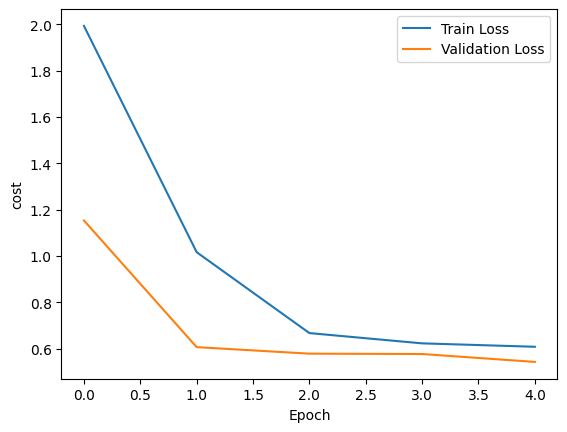

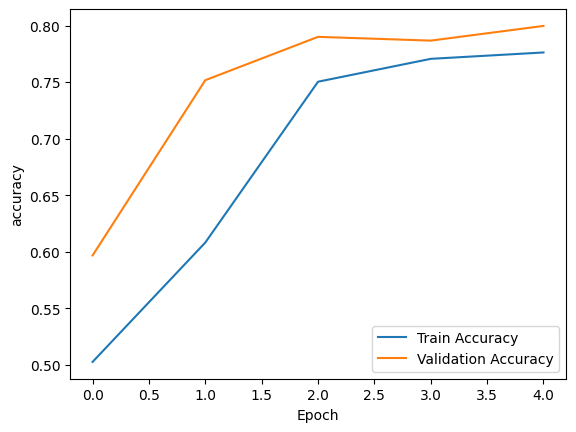

Epoch,▁▃▅▆█
training accuracy,▁▄▇██
training loss,█▃▁▁▁
validation accuracy,▁▆███
validation loss,█▂▁▁▁
Epoch,4
training accuracy,0.77619
training loss,0.60796
validation accuracy,0.79967
validation loss,0.54254


wandb: Agent Starting Run: g9808sxg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta: 0.999
wandb: 	epochs: 5
wandb: 	initialization: xavier
wandb: 	learning_rate: 0.01
wandb: 	loss: cross_entropy
wandb: 	num_neurons_in_hidden_layers: 128
wandb: 	number_of_hidden_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


run name = lr_0.01_op_adam_bs_64_loss_cross_entropy_wInit_xavier_hls_5_nhls_128_ac_sigmoid
********************************
Epoch Number = 0
Training Accuracy = 0.13368518518518518
Validation Accuracy = 0.20333333333333334
********************************
Epoch Number = 1
Training Accuracy = 0.09966666666666667
Validation Accuracy = 0.103
********************************
Epoch Number = 2
Training Accuracy = 0.09868518518518518
Validation Accuracy = 0.10083333333333333
********************************
Epoch Number = 3
Training Accuracy = 0.0995925925925926
Validation Accuracy = 0.10083333333333333
********************************
Epoch Number = 4
Training Accuracy = 0.09737037037037037
Validation Accuracy = 0.10016666666666667


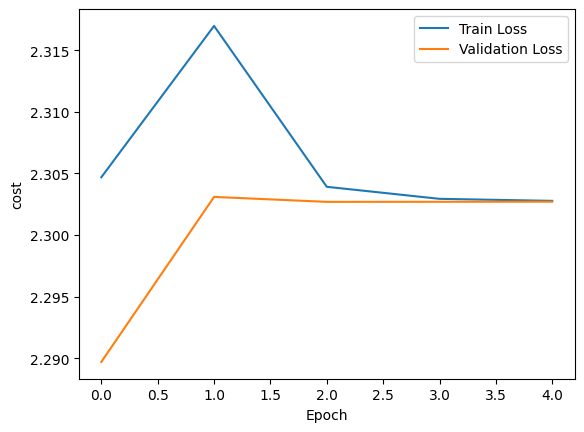

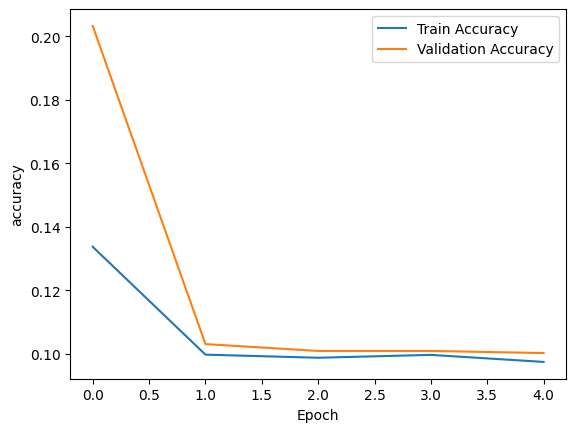

Epoch,▁▃▅▆█
training accuracy,█▁▁▁▁
training loss,▂█▂▁▁
validation accuracy,█▁▁▁▁
validation loss,▁████
Epoch,4
training accuracy,0.09737
training loss,2.30277
validation accuracy,0.10017
validation loss,2.3027


wandb: Agent Starting Run: 41klw1zy with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta: 0.999
wandb: 	epochs: 10
wandb: 	initialization: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	num_neurons_in_hidden_layers: 64
wandb: 	number_of_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


run name = lr_0.001_op_momentum_bs_64_loss_cross_entropy_wInit_xavier_hls_3_nhls_64_ac_relu
********************************
Epoch Number = 0
Training Accuracy = 0.5510555555555555
Validation Accuracy = 0.2728333333333333
********************************
Epoch Number = 1
Training Accuracy = 0.2608888888888889
Validation Accuracy = 0.30783333333333335
********************************
Epoch Number = 2
Training Accuracy = 0.45725925925925925
Validation Accuracy = 0.49483333333333335
********************************
Epoch Number = 3
Training Accuracy = 0.4446481481481481
Validation Accuracy = 0.44433333333333336
********************************
Epoch Number = 4
Training Accuracy = 0.2911666666666667
Validation Accuracy = 0.30416666666666664
********************************
Epoch Number = 5
Training Accuracy = 0.16683333333333333
Validation Accuracy = 0.22783333333333333
********************************
Epoch Number = 6
Training Accuracy = 0.20725925925925925
Validation Accuracy = 0.2321666

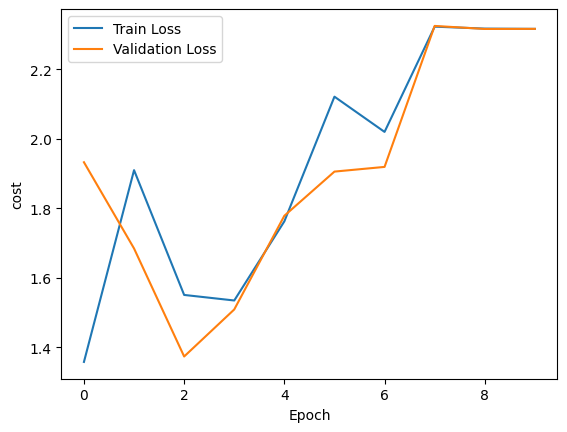

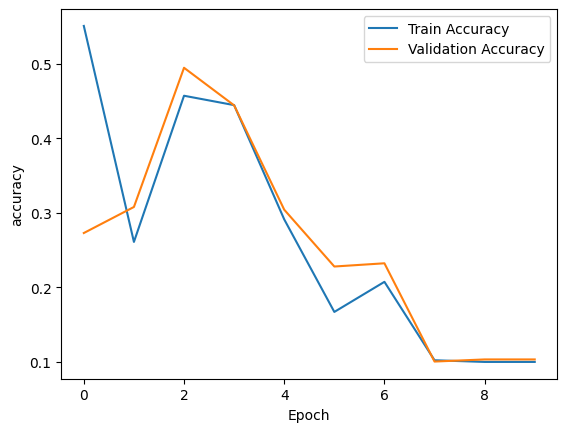

Epoch,▁▂▃▃▄▅▆▆▇█
training accuracy,█▄▇▆▄▂▃▁▁▁
training loss,▁▅▂▂▄▇▆███
validation accuracy,▄▅█▇▅▃▃▁▁▁
validation loss,▅▃▁▂▄▅▅███
Epoch,9
training accuracy,0.09967
training loss,2.31608
validation accuracy,0.103
validation loss,2.31606


wandb: Agent Starting Run: dsvvv8es with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	epochs: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	num_neurons_in_hidden_layers: 64
wandb: 	number_of_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


run name = lr_0.001_op_rmsprop_bs_16_loss_cross_entropy_wInit_random_hls_5_nhls_64_ac_relu
********************************
Epoch Number = 0
Training Accuracy = 0.18574074074074073
Validation Accuracy = 0.2628333333333333
********************************
Epoch Number = 1
Training Accuracy = 0.13387037037037036
Validation Accuracy = 0.2625
********************************
Epoch Number = 2
Training Accuracy = 0.2563888888888889
Validation Accuracy = 0.2901666666666667
********************************
Epoch Number = 3
Training Accuracy = 0.28429629629629627
Validation Accuracy = 0.314
********************************
Epoch Number = 4
Training Accuracy = 0.31507407407407406
Validation Accuracy = 0.3421666666666667


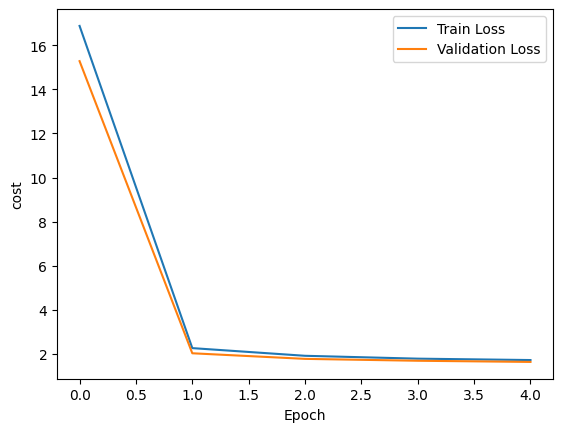

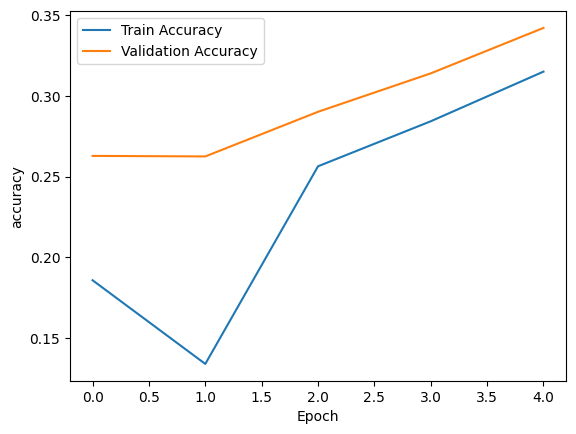

Epoch,▁▃▅▆█
training accuracy,▃▁▆▇█
training loss,█▁▁▁▁
validation accuracy,▁▁▃▆█
validation loss,█▁▁▁▁
Epoch,4
training accuracy,0.31507
training loss,1.72823
validation accuracy,0.34217
validation loss,1.6434


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 27r28jo3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	epochs: 10
wandb: 	initialization: xavier
wandb: 	learning_rate: 0.1
wandb: 	loss: cross_entropy
wandb: 	num_neurons_in_hidden_layers: 128
wandb: 	number_of_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


run name = lr_0.1_op_nadam_bs_16_loss_cross_entropy_wInit_xavier_hls_3_nhls_128_ac_relu
********************************
Epoch Number = 0
Training Accuracy = 0.40564814814814815
Validation Accuracy = 0.49083333333333334
********************************
Epoch Number = 1
Training Accuracy = 0.49992592592592594
Validation Accuracy = 0.6241666666666666
********************************
Epoch Number = 2
Training Accuracy = 0.6838148148148148
Validation Accuracy = 0.7705
********************************
Epoch Number = 3
Training Accuracy = 0.6131851851851852
Validation Accuracy = 0.683
********************************
Epoch Number = 4
Training Accuracy = 0.6589259259259259
Validation Accuracy = 0.7073333333333334
********************************
Epoch Number = 5
Training Accuracy = 0.7098333333333333
Validation Accuracy = 0.7558333333333334
********************************
Epoch Number = 6
Training Accuracy = 0.6934814814814815
Validation Accuracy = 0.7558333333333334
************************

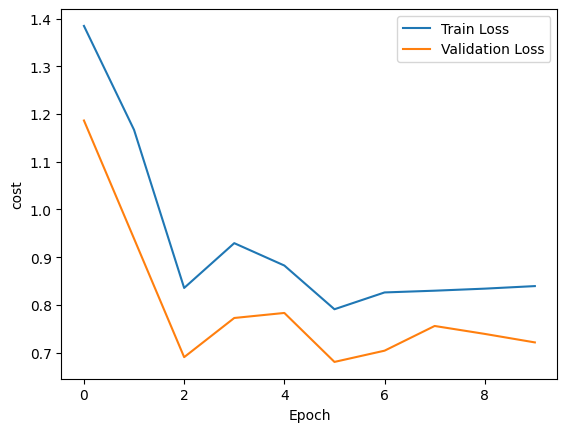

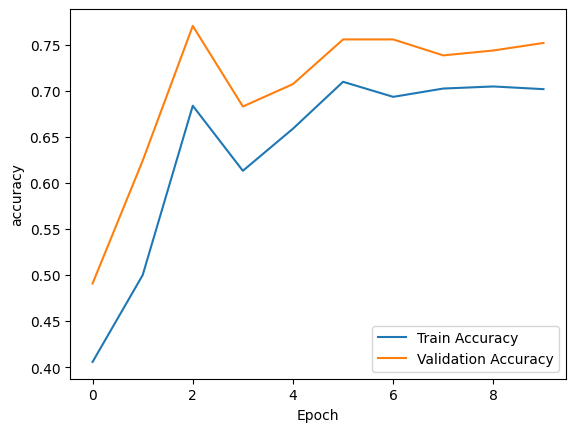

Epoch,▁▂▃▃▄▅▆▆▇█
training accuracy,▁▃▇▆▇█████
training loss,█▅▂▃▂▁▁▁▂▂
validation accuracy,▁▄█▆▆██▇▇█
validation loss,█▅▁▂▂▁▁▂▂▂
Epoch,9
training accuracy,0.70183
training loss,0.83929
validation accuracy,0.752
validation loss,0.72129


wandb: Agent Starting Run: 6ocxwebl with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta: 0.999
wandb: 	epochs: 5
wandb: 	initialization: xavier
wandb: 	learning_rate: 0.01
wandb: 	loss: cross_entropy
wandb: 	num_neurons_in_hidden_layers: 32
wandb: 	number_of_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


run name = lr_0.01_op_nadam_bs_32_loss_cross_entropy_wInit_xavier_hls_3_nhls_32_ac_relu
********************************
Epoch Number = 0
Training Accuracy = 0.7991851851851852
Validation Accuracy = 0.8415
********************************
Epoch Number = 1
Training Accuracy = 0.7635
Validation Accuracy = 0.831
********************************
Epoch Number = 2
Training Accuracy = 0.7511296296296296
Validation Accuracy = 0.825
********************************
Epoch Number = 3
Training Accuracy = 0.7558148148148148
Validation Accuracy = 0.8345
********************************
Epoch Number = 4
Training Accuracy = 0.7614814814814815
Validation Accuracy = 0.8365


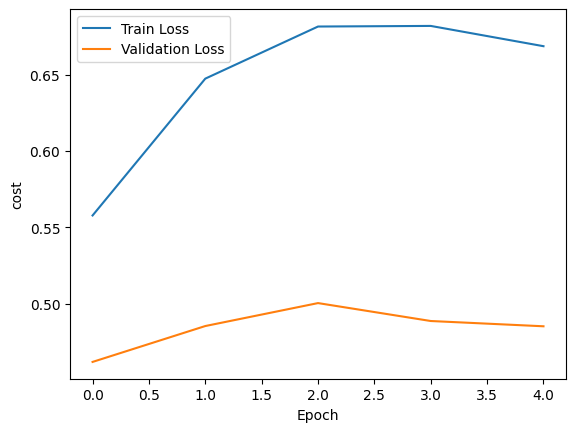

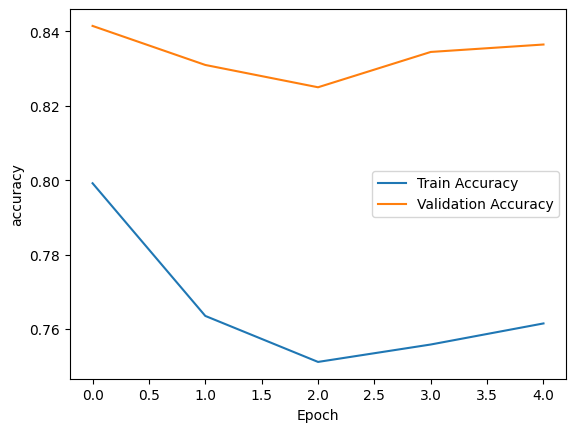

Epoch,▁▃▅▆█
training accuracy,█▃▁▂▃
training loss,▁▆██▇
validation accuracy,█▄▁▅▆
validation loss,▁▅█▆▅
Epoch,4
training accuracy,0.76148
training loss,0.66861
validation accuracy,0.8365
validation loss,0.48525


wandb: Agent Starting Run: 0kxzeysk with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	epochs: 5
wandb: 	initialization: xavier
wandb: 	learning_rate: 0.01
wandb: 	loss: cross_entropy
wandb: 	num_neurons_in_hidden_layers: 128
wandb: 	number_of_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


run name = lr_0.01_op_sgd_bs_16_loss_cross_entropy_wInit_xavier_hls_4_nhls_128_ac_relu


wandb: Ctrl + C detected. Stopping sweep.
wandb: ERROR Control-C detected -- Run data was not synced


In [ ]:
def main():
  wandb.init(project="Pritam CS6910 - Assignment 1")
  config=wandb.config

  Model=FeedForwardNeuralNetwork(x_train,y_train,x_val,y_val,hls=config.number_of_hidden_layers,neurons_in_hl=config.num_neurons_in_hidden_layers,activation=config.activation,initialization=config.initialization,epochs=config.epochs,eta=config.learning_rate)
  Model.modelFitting(beta=config.beta,beta1=0.9,beta2=0.999,eps=1e-5,optimizer=config.optimizer,batch_size=config.batch_size,loss=config.loss)

sweep_configuration = {
    'method': 'bayes',
    'name': 'ACCURACY VS EPOCH',
    'metric': {
        'goal': 'maximize',
        'name': 'validation_accuracy'
        },
    'parameters': {
        'initialization': {'values': ['xavier','random']},
        'number_of_hidden_layers' : {'values' : [3,4,5]},
        'num_neurons_in_hidden_layers' : {'values' : [32,64,128]},

        'learning_rate': {'values':[1e-1,1e-2,1e-3]},
        'beta' : {'values' : [0.9,0.999]},
        'optimizer' : {'values' : ['sgd','momentum','rmsprop','adam','nadam','nestrov']},

        'batch_size': {'values': [16,32,64]},
        'epochs': {'values': [5,10]},
        'loss' : {'values' : ['cross_entropy']},
        'activation' : {'values' : ['sigmoid','relu','tanh']}
       }
    }

sweep_id = wandb.sweep(sweep=sweep_configuration,project='Pritam CS6910 - Assignment 1')

wandb.agent(sweep_id , function = main , count = 160)
wandb.finish()

# y_test1=Model.one_hot_encoding(y_test)
# x_test1=Model.input_flattening(x_test)